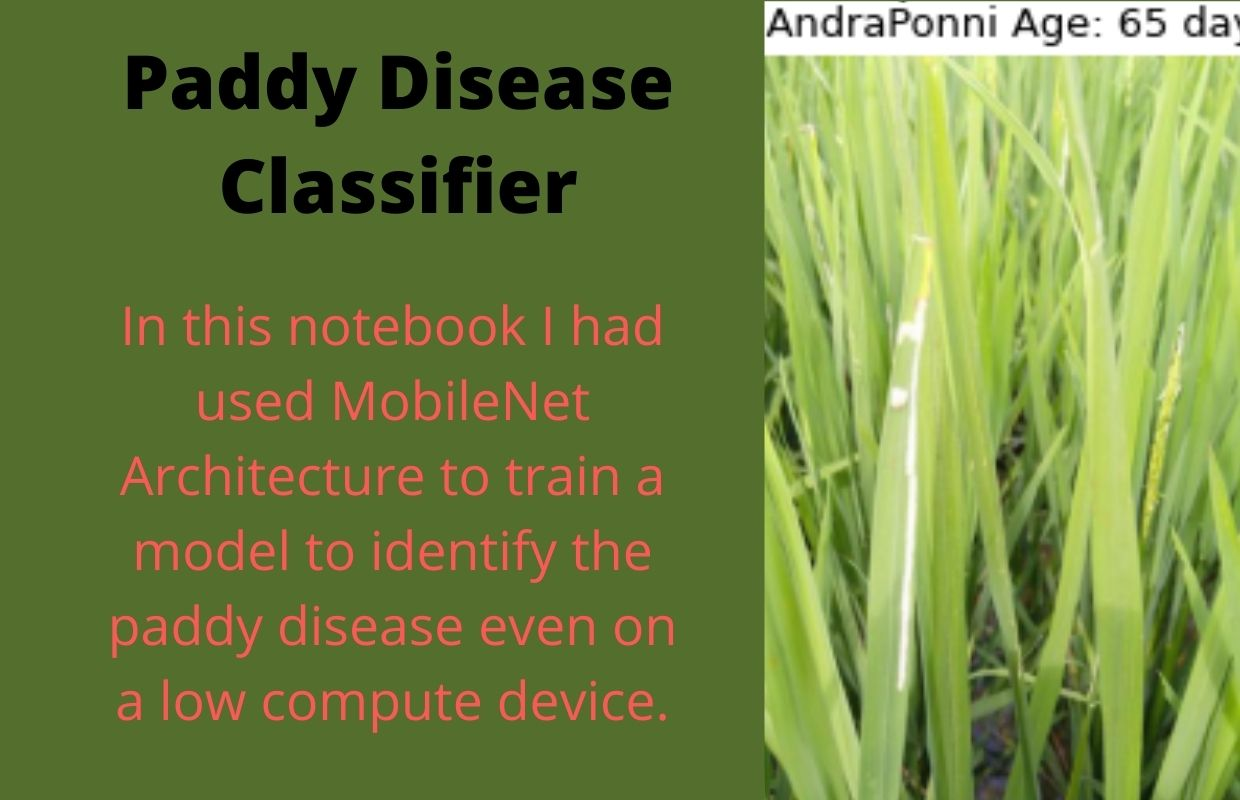

# <p style="text-align:center;font-size:150%;font-family:Roboto;background-color:#a04070;border-radius:50px;font-weight:bold;margin-bottom:0">Paddy Disease Classifier</p>

<p style="font-family:Roboto;font-size:130%;color:#a04070;margin-up:0">In this Notebook, I had used tranfer learning by using MobileNet Architecture to classify different diseases found in the paddy crops for it's whole life cycle. By trading off with a little bit of accuracy MobileNet architecture is a state of the art model which require very less compute power to perform on mobile devices which have very limited memory and compute resources.</p> 

<!-- <a id='top'></a> -->
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#a04070;font-family:Roboto;font-size:170%;text-align:center;border-radius:50px;">TABLE OF CONTENTS</p>   
    
* [1. Importing Libraries](#1)
    
* [2. Data Exploration & Visualising Images](#2)
    
* [3. Transfer Learning Using Mobile Net](#3)
    
* [4. Fine Tuning The Model](#4)
    
* [5. The End](#5)


<a id="1"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">IMPORTING LIBRARIES</p>    

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory


<a id="2"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Data Exploration and Visualising Images</p>

In [ ]:
df = pd.read_csv('../input/paddy-disease-classification/train.csv')
df.shape

In [ ]:
df.head()

In [ ]:
df.groupby('variety').mean()

<p style="font-family:Roboto;font-size:130%;color:#a04070;">If we ignore the <code>SURYA</code> variety of crop then we can observe that the paddy crops lifecycle varies in the range of 60 - 70 days. </p> 

In [ ]:
plt.figure(figsize=(10,10))
sb.countplot(data=df, x='variety')
plt.xticks(rotation = 90)
plt.show()

<p style="font-family:Roboto;font-size:130%;color:#a04070;">Most of the paddy crops in the given dataset is of variety <code>ADT45</code>(it seems like this is the first choice of the farmers factors can be success rate or demand) and in total we have 10 variety of crops.</p> 

In [ ]:
plt.figure(figsize=(10,10))
sb.countplot(df['label'])
plt.xticks(rotation = 90)
plt.show()

<ul style="font-family:Roboto;font-size:130%;color:#a04070;"><li>The dataset provided is uneven means does not include equal number of training examples for each type of disease class which can make it difficult for the model to learn better parameters to generalize for each of the 9 disease classes and one normal class.</li>
<li>I can think of one reason for this uneven nature of the dataset that some diseases quite common than the others in the paddy crops.</li></ul>

In [ ]:
plt.figure(figsize=(10,10))
sb.countplot(df['age'])
plt.show()

<ul style="font-family:Roboto;font-size:160%;color:#a04070;">Now let's visualise the some crop images from each of the 10 given categories to get an idea of the images.</p>

In [ ]:
base_path = '../input/paddy-disease-classification/train_images/'
diseases = os.listdir(base_path)


for dis in diseases:
    disease_specific = df[df['label']==dis]
    
    index_list = disease_specific.index
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'Images for {dis} category . . . .', fontsize=20)
    for i in range(3):
        index = np.random.randint(0,len(index_list))
        index = index_list[index]
        data = df.iloc[index]
        
        
        image_path = f'{base_path}{dis}/{data[0]}'
        
        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
        ax[i].set_title(f'Type: {data[2]} Age: {data[3]}', fontsize=13)
        ax[i].axis('off')  #As all the images are of 480 x 640 dimension as per the data section.
    plt.show()

<a id="3"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Transfer Learning Using MobileNet</p> 
<p style="font-family:Roboto;font-size:140%;color:#a04070;margin-up:0">We will use MobileNet Architecture which is 155 layers deep even then it takes very less compute power to give excellent results. It's unique feature are Depthwise Seperable Convolutions which helps in light weight feature filtering and skip connections which helps to preserve important information in deeper layers of the network.</p> 

In [ ]:
labels = os.listdir('../input/paddy-disease-classification/train_images')
img_size = 400

train_dataset = image_dataset_from_directory(
    '../input/paddy-disease-classification/train_images',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=True,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='training',
    seed=22
)


val_dataset = image_dataset_from_directory(
    '../input/paddy-disease-classification/train_images',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=False,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='validation',
    seed=22
)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def get_model(base, preprocessor, img_size):    
    inputs = tf.keras.Input(shape=(img_size,img_size,3))
    x = RandomFlip('horizontal')(inputs)
    x = preprocessor(x)
    x = base(x)

    x = tfl.Flatten()(x)
    x = tfl.Dense(1024, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu')(x)
    x = tfl.Dropout(0.15)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(64, activation='relu')(x)
    x = tfl.Dropout(0.3)(x)
    x = tfl.BatchNormalization()(x)
    outputs = tfl.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=(img_size,img_size,3),
                                         include_top=False,
                                         weights='imagenet')

pre_trained_model.trainable = False

In [ ]:
model = get_model(pre_trained_model, preprocess_input, img_size)

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5,
                    verbose=1)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

<a id="4"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Fine Tuning The Model</p> 
<p style="font-family:Roboto;font-size:140%;color:#a04070;margin-up:0">As we know that the deeper layers of a CNN represent complex features and the performance of the model depend upon the features identified by them. So, if we will train some of the deeper layers of the original model we can customize the model to best fit to the task at hand.</p> 

In [ ]:
print('Number of layers in the MobileNetV2 Model : ', len(pre_trained_model.layers))


# Here I am training the layers from 120th layer onwards.
for layer in pre_trained_model.layers[120:]:
    layer.trainable=True

In [ ]:
model_tuned = get_model(pre_trained_model, preprocess_input, img_size)

model_tuned.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_tuned = model_tuned.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=14,
                    verbose=1)

In [ ]:
history_df = pd.DataFrame(history_tuned.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

<ul style="font-family:Roboto;font-size:140%;color:#a04070;margin-up:0">Important points observed while fine tuning the model:<li>Higher number of epochs are required as I am training more number of layers.</li><li> And the explicitly defining the learning rate and quite low otherwise the learning of the model is quite unstable sometimes performance goes up and sometimes goes down.</li><li>Fine tuning the model has certainly helped to improve the performance of the model both on training and the validation set.</li></ul> 

In [ ]:
test_dataset = image_dataset_from_directory(    
    '../input/paddy-disease-classification/test_images',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=False,
    labels=None,
    class_names = None,
    label_mode = None,
    color_mode='rgb',
)

In [ ]:
predictions = model_tuned.predict(test_dataset)
predictions.shape

In [ ]:
ss = pd.read_csv('../input/paddy-disease-classification/sample_submission.csv')
ss['label'] = np.argmax(predictions, axis=-1)
ss['label'] = ss['label'].replace([0,1,2,3,4,5,6,7,8,9], labels)
ss.to_csv("Submission.csv",index=False)
ss.head()

<a id="5"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">The End</p> 
<p style="font-family:Roboto;font-size:140%;color:#a04070;margin-up:0">At first it seems like this is one of the competition which will require FGVC concepts as we have to classify between categories which are quite similar. But as I went through some of the kernels I realised this is not the case. Why I don't know? But it was a fun experience. Feel free to ask if you have any doubt in this notebook.</p> 